# Reproducible Analysis

## Improve the Countryside Listing’s Performance in London by Text Analysis
* The purpose of this analysis is to study the listing textual information’s impact on the different performance of the countryside listings in London. 

* Recommendations were given based on the analysis to improve the countryside market in London. The results and recommendations would be the support for further expenditure decisions of the chief executives in Airbnb company.

* The Airbnb listing data used in this study is from the website [InsideAirbnb.com](http://insideairbnb.com/get-the-data.html), which provides publicly available Airbnb listing data, containing text descriptions about the listings. It is a snapshot of Airbnb listings in London between 2020-8-24 to 2020-8-28.

* The listing data we used could be downloaded here: [2020-08-24-listings](https://github.com/jreades/i2p/raw/master/data/src/2020-08-24-listings.csv.gz)
* The London borough data could be downloaded here: [Boroughs.gpkg](https://github.com/jreades/fsds/raw/master/data/src/Boroughs.gpkg)
* If you are running this notebook in the file "reproducible_analysis_casa0013", then you don't need to download any data, all the data needed are in that file.

### Import modules and create some functions
Firstly, we need to import the necessary libaries:

In [1]:
import os
import pandas as pd
import geopandas as gpd
import re
import string
import unicodedata
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt
import json
import numpy as np
import seaborn as sns
import matplotlib.cm as cm

Here are some libraries for NLP analysis

In [2]:
from sklearn.preprocessing import OneHotEncoder 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import nltk
import spacy
#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.corpus import stopwords
stopword_list = set(stopwords.words('english'))

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
#from nltk.tokenize.stanford import StanfordTokenizer

from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from nltk import ngrams, FreqDist

lemmatizer = WordNetLemmatizer()
tokenizer = ToktokTokenizer()

This next is a function that allows us to output Markdown instead of plain text:

In [3]:
from IPython.display import display_markdown

def as_markdown(head='', body='Some body text'):
    if head != '':
        display_markdown(f"##### {head}\n\n>{body}\n", raw=True)
    else:
        display_markdown(f">{body}\n", raw=True)

This next is a [function created by Tianyi Wang in Kaggle](https://www.kaggle.com/tianyiwang/become-a-data-driven-airbnb-host-part-1/notebook) to show the the shape of a dataframe, the percentage of features without missing values and the columns with high missing rates:

In [4]:
def data_first_look(df):
    '''
    print out the shape of a dataframe, the percentage of features without missing values and the columns with high missing rates
    '''
    print(f"Data has in total {df.shape[0]} rows and {df.shape[1]} features.")
    missing_rates = pd.DataFrame(df.isna().mean())\
                    .rename({0:'perc_missing'}, axis=1)\
                    .sort_values('perc_missing', ascending=False)
    print("{}% of the features don't have missing values"\
          .format(round(sum(missing_rates['perc_missing']==0)*100/len(missing_rates), 2)))
    missing_rates[missing_rates['perc_missing']>0].plot.bar(title="Missing rates")

Import the Custom Module for document nomalisation

In [5]:
from textual import *

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [6]:
# test
as_markdown('Normalised', normalise_document('ab,1,apple,man,banana,bananas,men'))

#### Normalised

>apple man banana banana men


### read in data

Read in the Airbnb listing data of London

In [7]:
url = '2020-08-24-listings.csv' 

raw_data = pd.read_csv(url)

F:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (2,22,36,41,45,46,55) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Check the information of this data

In [8]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74188 entries, 0 to 74187
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            74186 non-null  float64
 1   listing_url                                   74187 non-null  object 
 2   scrape_id                                     74187 non-null  object 
 3   last_scraped                                  74187 non-null  object 
 4   name                                          74167 non-null  object 
 5   description                                   71329 non-null  object 
 6   neighborhood_overview                         47208 non-null  object 
 7   picture_url                                   74188 non-null  object 
 8   host_id                                       74188 non-null  float64
 9   host_url                                      74188 non-null 

The raw data contains too many colomns, we could select the columns we need:

In [9]:
# select the columns needed

cols = ['id','listing_url','name','price','description','host_id','neighborhood_overview','host_about','host_listings_count',
        'latitude','longitude','property_type','room_type','accommodates','review_scores_rating','amenities']


df = pd.read_csv(url, usecols=cols)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74188 entries, 0 to 74187
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     74186 non-null  float64
 1   listing_url            74187 non-null  object 
 2   name                   74167 non-null  object 
 3   description            71329 non-null  object 
 4   neighborhood_overview  47208 non-null  object 
 5   host_id                74188 non-null  float64
 6   host_about             42494 non-null  object 
 7   host_listings_count    74175 non-null  float64
 8   latitude               74186 non-null  float64
 9   longitude              74186 non-null  float64
 10  property_type          74186 non-null  object 
 11  room_type              74186 non-null  object 
 12  accommodates           74186 non-null  float64
 13  amenities              74186 non-null  object 
 14  price                  74186 non-null  object 
 15  re

Change the format of the "price" column:

In [11]:
# change the price format
df.price.str.replace('$','')
df['price'] = df.price.str.replace('$','').str.replace(',','').astype(float)

<ipython-input-11-d23651318a4b>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.price.str.replace('$','')
<ipython-input-11-d23651318a4b>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['price'] = df.price.str.replace('$','').str.replace(',','').astype(float)


Filter the rows out of the of London by the latitude and longitude:

In [12]:
# filter rows out of the London area
df.drop(df[df.latitude.isna()|df.longitude.isna()].index, axis=0, inplace=True)
df.drop(df[((df.latitude < 40)|(df.longitude > 1))].index, axis=0, inplace=True)
print(df.shape)

(74184, 16)


In [13]:
df.groupby(['room_type'])['price'].mean()

room_type
Entire home/apt    164.472148
Hotel room         129.579549
Private room        61.696273
Shared room         56.309595
Name: price, dtype: float64

After the basic data preparing, use the data_first_look function to see the missing values of the dataframe:


It can be seen that "host_about" has over 40% missing values, "description" column is important to this study, it doesn't have too many NAs which is good. 

Data has in total 74184 rows and 16 features.
62.5% of the features don't have missing values


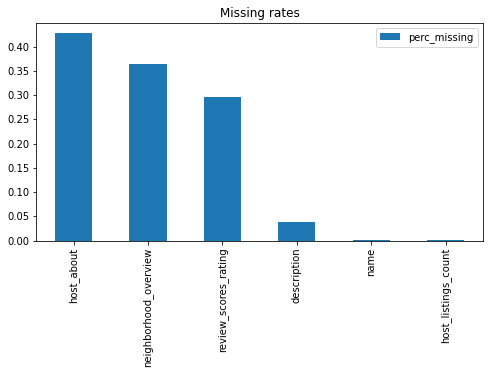

In [14]:
# use data_first_look function to see the missing values of the dataframe

plt.rcParams['figure.figsize'] = (8,4)
data_first_look(df)

The detailed information of the missing value of different columns

In [15]:
df.isna().sum().sort_values(ascending=False)

host_about               31694
neighborhood_overview    26980
review_scores_rating     21901
description               2859
name                        21
host_listings_count          9
id                           0
listing_url                  0
host_id                      0
latitude                     0
longitude                    0
property_type                0
room_type                    0
accommodates                 0
amenities                    0
price                        0
dtype: int64

There are 2859 missing values in the "description" column from the cell above

### Convert to GeoPandas

Read in the Boroughs GeoPackage: 

<AxesSubplot:>

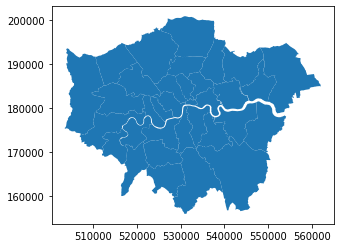

In [16]:
boros = gpd.read_file('Boroughs.gpkg')
boros.plot()

Convert df to gdf from DataFrame to GeoDataFrame by the longitude and latitude:

In [17]:
# convert df to gdf
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude, crs='epsg:4326'))
gdf = gdf.to_crs('epsg:27700')

In [18]:
gdf.shape

(74184, 17)

Combine gdf and borough:

In [19]:
# combine gdf and borough
gdf_bo = gpd.sjoin(gdf, boros, op='within', how='left')


F:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3357: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [20]:
gdf_bo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 74184 entries, 0 to 74187
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id                     74184 non-null  float64 
 1   listing_url            74184 non-null  object  
 2   name                   74163 non-null  object  
 3   description            71325 non-null  object  
 4   neighborhood_overview  47204 non-null  object  
 5   host_id                74184 non-null  float64 
 6   host_about             42490 non-null  object  
 7   host_listings_count    74175 non-null  float64 
 8   latitude               74184 non-null  float64 
 9   longitude              74184 non-null  float64 
 10  property_type          74184 non-null  object  
 11  room_type              74184 non-null  object  
 12  accommodates           74184 non-null  float64 
 13  amenities              74184 non-null  object  
 14  price                  74184 n

### Previewing Textual Data

Set the tsxt display length:

In [21]:
print(pd.options.display.max_colwidth) 
pd.options.display.max_colwidth=200 

50


### Using Regular Expressions to identify the countryside listings


First, check the missing value in "description" column and "amenities" column

In [22]:
gdf_bo[gdf_bo.description.isna()].shape

(2859, 23)

In [23]:
gdf_bo[gdf_bo.amenities.isna()].shape

(0, 23)

 "description" column has 2859 missing values and "amenities" column has no missing values

Remove all the rows without "description" value

In [24]:
# Remove the rows with description missing
gdf_bo.drop(index=(gdf_bo[gdf_bo.description.isna()].index), inplace=True)
print(gdf_bo.shape)

(71325, 23)


Here use "countryside", "rural" and "village" in the regular expression to identify the countryside listings:

In [25]:
countryside = gdf_bo[gdf_bo.description.str.contains(r'(?:countryside|rural|village)', regex=True, flags=re.IGNORECASE)].copy()

In [26]:
countryside.shape

(2458, 23)

Here we plot the countryside listings

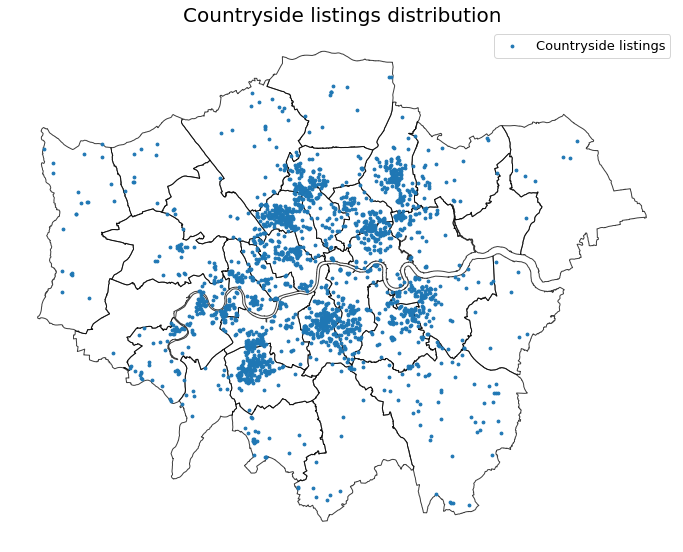

In [27]:
ax = boros.plot(figsize=(12,10), edgecolor='black', facecolor='none', linewidth=1, alpha=0.75)
countryside.plot(markersize=8,ax=ax,label='Countryside listings',legend=True)
ax.set_title('Countryside listings distribution', fontdict={'fontsize':'20', 'fontweight':'3'})  #provide a title

ax.axis('off')
plt.legend()
ax.legend(fontsize = 13)
plt.show()

From the plot above we can see that countryside listings are basically distributed around the centre of London.

##### Select the Good listings and the Normal listings

"review_scores_rating" is an index which indicates the customer's satisfaction for the listing. In this study, we use this to represent the performance of countryside listings.

First, we will check the distribution of the review score rating of all the countryside listings:

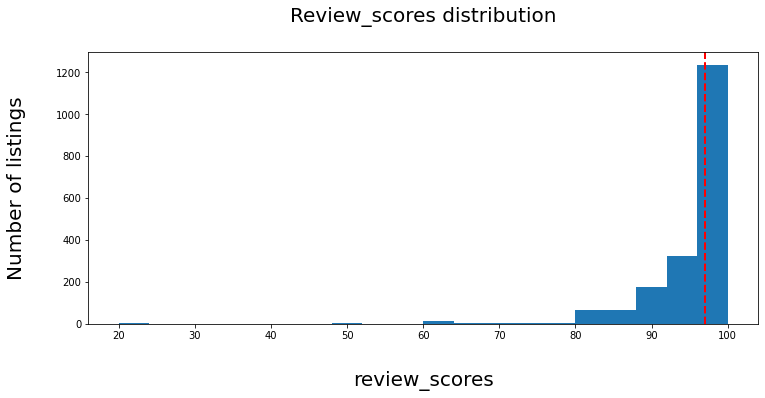

In [28]:
fig, ax = plt.subplots(1,1, figsize = (12,5))
ax.hist(x = countryside.review_scores_rating, bins = 20)
ax.set_title("Review_scores distribution", fontsize = 20, pad = 30)
ax.set_xlabel("review_scores", fontsize = 20, labelpad = 30)
ax.set_ylabel("Number of listings", fontsize = 20, labelpad = 30)
ax.axvline(countryside.review_scores_rating.median(), color='r', linestyle='dashed', linewidth=2)


In [29]:
# median value of the review score
countryside.review_scores_rating.median()

97.0

From the histogram plot above we can see that the distribution of the review score is highly skewed and the median value of it is 97.0 (the read dashed line on the plot above).

To find reason why some listings perform well (get higher review scores) in the countryside, listings were divided into two sub-groups, one is the “good listings” with the review score is 100, another is the “normal listings” with the score below 95.

In [30]:
# filter the Good listings
countryside_good = countryside[countryside.review_scores_rating ==100]
countryside_good.shape

(646, 23)

In [31]:
# filter the Normal listings
countryside_normal = countryside[countryside.review_scores_rating<95]
countryside_normal.shape

(569, 23)

In [32]:
# filter the listings without review score
countryside_na = countryside[countryside.review_scores_rating.isna()]
countryside_na.shape

(549, 23)

It is noted that there are some listings without the review score, this may be because those listings haven't gotten enough review, therefore, we would not consider those listings in this study.  

Here we plot the Good listings and the Normal listings to see if there are any geographical clusters:

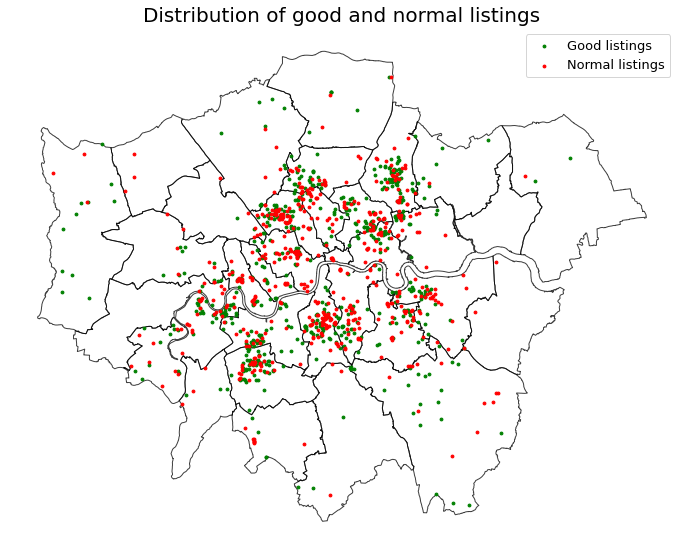

In [33]:
# plot the Good listings and the Normal listings 


ax = boros.plot(figsize=(12,10), edgecolor='black', facecolor='none', linewidth=1, alpha=0.75)

countryside_good.plot(color="green",markersize=8,ax=ax, legend=True,label="Good listings",)
countryside_normal.plot( color="red",markersize=8,ax=ax, legend=True,label="Normal listings")

ax.set_title('Distribution of good and normal listings', fontdict={'fontsize':'20', 'fontweight':'3'})  #provide a title

ax.axis('off')
plt.legend()
ax.legend(fontsize = 13)
plt.show()

From the plot above, we can see the Good listings and Normal listings mix with each other. If some areas have better natural resource or attractions then the listings there would be more likely to be “good” listings. Therefore, It could be inferred that the performance of countryside listings may not be highly influenced by the spatial factors.

### LDA topic model analysis for the listing description

#### Create corpus 

First, creat the corpus for good listings and normal listings:

In [34]:
# Create the corpus of good listings
countryside_good['description_norm'] = countryside_good.description.apply(normalise_document)

F:\anaconda3\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [35]:
corpus_countryside_good = countryside_good.description_norm.fillna(' ').values
corpus_countryside_good.shape

(646,)

In [36]:
# Create the corpus of normal listings
countryside_normal['description_norm'] = countryside_normal.description.apply(normalise_document)

In [37]:
corpus_countryside_normal = countryside_normal.description_norm.fillna(' ').values
corpus_countryside_normal.shape

(569,)

Check the result of the corpus:

In [38]:
print(corpus_countryside_good[0:2])

['comfortable modern home friendly host offer handful hint need space hello two bedroom apartment leytonstone east london nicely decorate apartment mod con high ceiling give spacious feel clean original wooden floor two bedroom apartment locate nice quiet residential road parking free ideally locate a12 short 5mins walk local tescos superstore pub restaurant give village feel area walk distance 7mins leytonstone tube station 5mins walk epping forest hollow pond boat available hire 2mins walk tescos tube journey leytonstone central line 3mins stratford westfield shopping centre olympic villiage 25mins london west end oxford bond 2mins leyton fitness first gym'
 'recently refurbish sunny one bedroom first floor apartment space family friendly accommodation london minute drive gatwick airport mile south london ideally situate offer tourist easy access central london major site greenwich kent countryside also accessible large garden lawn patio area complete furniture child variety outdoor 

In [39]:
print(corpus_countryside_normal[0:2])

['double bed 1st floor extra single bed room move large room floor use fridge room summer balcony coffee tea close high road great transport local cafe restaurant access town river thames summer event bustlling village feel area minimum night stay booking name person guest 3rd party booking key 100 charge lose replace lock copy space min tube zone chiswick high road cafes bar restaurant mile kew garden double room bathroom with double bed single fold bed sleep include fold out bed nice apartment bed 1st floor room brass bed double size next bathroom flat floor reception kitchen balcony 100m high road wit'
 'munster village colourful collection shop restaurant plus amnities end quiet safe street thai italian french english restaurant choose plus antique shop browse easy access centre space newly decorate double single room bed quiet safe neighbourhood non smoke house share bathroom smart freeview netflix room bill wireless internet include price weekly cleaning change linen house well s

#### LDA topic model

##### LDA for Good listings:

In [40]:
# make the doc-term matrix
vectorizer_good = CountVectorizer(max_df=0.8, min_df=2,stop_words='english')
vectorizer_good.fit(corpus_countryside_good) 
countryside_good_mtrix = vectorizer_good.transform(corpus_countryside_good) # tcorpus for transformed corpus

In [41]:
countryside_good_mtrix.shape

(646, 2045)

In [42]:
# LDA, choose components=15
countryside_good_LDA = LatentDirichletAllocation(n_components=15, random_state=42) # Might want to experiment with n_components too
countryside_good_LDA.fit(countryside_good_mtrix)

LatentDirichletAllocation(n_components=15, random_state=42)

In [43]:
# Check the 15 topics for good listings
for i,topic in enumerate(countryside_good_LDA.components_):
    as_markdown(f'Top 15 words for topic #{i}', ', '.join([vectorizer_good.get_feature_names()[i] for i in topic.argsort()[-15:]]))

#### Top 15 words for topic #0

>rain, large, light, guest, fully, feel, road, finish, high, shower, bedroom, kitchen, walk, bathroom, apartment


#### Top 15 words for topic #1

>shop, street, brixton, end, tube, flat, min, clapham, away, park, house, restaurant, minute, london, walk


#### Top 15 words for topic #2

>hill, quiet, open, park, locate, apartment, area, garden, large, private, kitchen, london, room, bedroom, floor


#### Top 15 words for topic #3

>thing, like, note, home, london, kitchen, street, bedroom, guest, room, flat, garden, area, access, house


#### Top 15 words for topic #4

>restaurant, brixton, lovely, guest, park, home, central, apartment, bedroom, enjoy, station, min, walk, minute, london


#### Top 15 words for topic #5

>bus, station, area, house, home, line, minute, park, family, central, min, access, greenwich, walk, london


#### Top 15 words for topic #6

>lovely, beautiful, boy, private, access, family, house, bedroom, double, garden, home, bathroom, flat, kitchen, room


#### Top 15 words for topic #7

>bedroom, area, bed, park, access, room, heath, highgate, walk, london, garden, place, min, house, hampstead


#### Top 15 words for topic #8

>living, spacious, sofa, modern, large, walk, bathroom, double, room, apartment, london, flat, kitchen, bedroom, bed


#### Top 15 words for topic #9

>city, restaurant, property, canary, wharf, camden, apartment, bedroom, private, tube, park, station, minute, walk, london


#### Top 15 words for topic #10

>road, room, restaurant, away, shoreditch, minute, heart, canal, min, walk, bedroom, london, victoria, flat, park


#### Top 15 words for topic #11

>available, garden, locate, court, minute, bedroom, area, park, station, beautiful, walk, min, southfields, tennis, wimbledon


#### Top 15 words for topic #12

>bus, flat, station, away, guest, train, room, min, central, access, house, walk, london, wimbledon, minute


#### Top 15 words for topic #13

>park, minute, large, house, flat, bathroom, area, double, guest, garden, london, access, kitchen, bedroom, room


#### Top 15 words for topic #14

>bed, kitchen, home, large, locate, family, open, modern, bedroom, road, station, garden, london, room, house


From the LDA topic model above, we get the 15 topics of good listings' description, we will do the same for normal listings later. Detailed interpretation of the topics can be found in the Executive Briefing.

Here we add the topic back to the good listings dataframe:

In [44]:
# add the topic back to the data
topic_values_good = countryside_good_LDA.transform(countryside_good_mtrix)

In [45]:
topic_values_good.shape

(646, 15)

Choose the topic with the highest proportion of one listing as its Topic.:

In [46]:
# Choose the topic with the highest proportion of one listing as its Topic.  
countryside_good['Topic'] = topic_values_good.argmax(axis=1)

Calculate the amount of each topic:

In [47]:
countryside_good.groupby(['Topic']).size().sort_values(ascending=False)

Topic
13    169
8     110
2      61
12     56
5      51
7      33
3      32
4      32
1      23
10     22
14     17
9      14
0      11
11      9
6       6
dtype: int64

From the 15 topics' keywords, We can see that some topics have many key words in common, therefore, it is reasonable to allocate them into several catrgories so that we can compare them easily and effectively. 

The topics were allocated into THREE categories: "Indoor features","Convenience","Surrounding characteristics". The detailed information about the 3 topic categories could be found in the Executive Briefing.

Here we are creating a new column 'Topic Category' to store the topic category of each listing:

In [48]:
# each of 15 good listings' topics from LDA topic model were allocated in to one of the three categories, 
# detailed information is inExecutive Briefing :

indoor_features_topic_good = [0,2,3,6,8,13,14]
convenience_topic_good  = [1,4,9,12] 
surrounding_characteristics_good = [5,7,10,11]

In [49]:
for i in indoor_features_topic_good:
    countryside_good.loc[countryside_good['Topic'] == i, 'Topic Category'] = 1

for j in convenience_topic_good:
    countryside_good.loc[countryside_good['Topic'] == j, 'Topic Category'] = 2

for m in surrounding_characteristics_good:
    countryside_good.loc[countryside_good['Topic'] == m, 'Topic Category'] = 3

F:\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Check the category of good listings using groupby:

In [50]:
topic_category_good = countryside_good.groupby(['Topic Category']).size().sort_values(ascending=False)

In [51]:
topic_category_good = pd.DataFrame(topic_category_good)

In [52]:
# check the percentage of each category
topic_category_good['percentage_good'] = topic_category_good/646

In [53]:
topic_category_good

,0,percentage_good
Topic Category,,
1.0,406,0.628483
2.0,125,0.193498
3.0,115,0.178019


From the DataFrame above we can see that, in Good listings category 1(indoor_features) accounts for 62% of all the listings which is dominant. Later we will do the same for the Normal listings and we can see the difference.

##### LDA for Normal listings:

In [54]:
# make the doc-term matrix
vectorizer_normal = CountVectorizer(max_df=0.8, min_df=2,stop_words='english')
vectorizer_normal.fit(corpus_countryside_normal) 
countryside_normal_mtrix = vectorizer_normal.transform(corpus_countryside_normal) # tcorpus for transformed corpus

In [55]:
countryside_normal_mtrix.shape

(569, 1934)

In [56]:
# LDA, choose components=15, which is the same as the good listings
countryside_normal_LDA = LatentDirichletAllocation(n_components=15, random_state=42) # Might want to experiment with n_components too
countryside_normal_LDA.fit(countryside_normal_mtrix)

LatentDirichletAllocation(n_components=15, random_state=42)

In [57]:
for i,topic in enumerate(countryside_normal_LDA.components_):
    as_markdown(f'Top 15 words for topic #{i}', ', '.join([vectorizer_normal.get_feature_names()[i] for i in topic.argsort()[-15:]]))

#### Top 15 words for topic #0

>shower, large, apartment, area, double, bed, floor, flat, bedroom, london, bathroom, kitchen, guest, access, room


#### Top 15 words for topic #1

>flat, square, double, pimlico, dulwich, london, westminster, guest, station, walk, city, house, victoria, bedroom, room


#### Top 15 words for topic #2

>restaurant, park, station, include, central, room, flat, bus, away, walk, guest, access, minute, brixton, london


#### Top 15 words for topic #3

>primrose, perfect, hampstead, welcome, away, belsize, hill, access, flat, camden, studio, central, park, apartment, london


#### Top 15 words for topic #4

>bathroom, chelsea, short, room, inside, walk, heart, park, area, building, guest, kitchen, london, studio, apartment


#### Top 15 words for topic #5

>london, guest, access, close, park, solo, yol, adventurer, family, good, love, couple, traveller, business, place


#### Top 15 words for topic #6

>towel, dulwich, breakfast, come, kitchen, restaurant, greenwich, house, use, iron, east, park, room, london, free


#### Top 15 words for topic #7

>sofa, access, garden, house, area, london, living, home, flat, large, double, kitchen, room, bed, bedroom


#### Top 15 words for topic #8

>tube, line, shop, street, central, bus, train, house, flat, park, away, station, walk, london, minute


#### Top 15 words for topic #9

>towel, fridge, flat, clean, machine, freezer, professionally, kitchen, bed, linen, microwave, hotel, stay, fully, oven


#### Top 15 words for topic #10

>richmond, yol, short, good, close, thing, min, homely, putney, http, www, hampton, place, love, guest


#### Top 15 words for topic #11

>tube, flat, large, tennis, restaurant, bedroom, london, park, station, min, minute, house, room, walk, wimbledon


#### Top 15 words for topic #12

>access, high, garden, quiet, park, room, central, street, station, locate, min, area, apartment, london, walk


#### Top 15 words for topic #13

>free, bedroom, distance, double, kitchen, restaurant, close, london, great, park, guest, house, walk, room, access


#### Top 15 words for topic #14

>minute, road, open, bed, train, lovely, town, thames, river, walk, park, kew, house, richmond, garden


Here we did the same for normal listings as we did above for good listings to add the topic back to the nomal listing dataframe: 

In [58]:
# add the topic back to the data
topic_values_normal = countryside_normal_LDA.transform(countryside_normal_mtrix)

In [59]:
topic_values_normal.shape

(569, 15)

In [60]:
countryside_normal['Topic'] = topic_values_normal.argmax(axis=1)

F:\anaconda3\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [61]:
countryside_normal.groupby(['Topic']).size().sort_values(ascending=False)

Topic
0     148
8      97
7      90
11     45
12     42
2      31
3      22
14     20
4      18
13     18
6      14
9       8
1       7
5       7
10      2
dtype: int64

In [62]:
countryside_normal.Topic

21        0
26        6
62       12
134       0
146       8
         ..
67733     7
71008     0
72025     0
72115    12
72302    13
Name: Topic, Length: 569, dtype: int64

The topics for Normal listings were also allocated into three categories: "Indoor features","Convenience","Surrounding characteristics":

In [63]:
indoor_features_topic_normal = [0,4,7,9]
convenience_topic_normal  = [2,8,12,13] 
surrounding_characteristics_normal = [1,3,5,6,10,11,14]

In [64]:
for i in indoor_features_topic_normal:
    countryside_normal.loc[countryside_normal['Topic'] == i, 'Topic Category'] = 1

for j in convenience_topic_normal:
    countryside_normal.loc[countryside_normal['Topic'] == j, 'Topic Category'] = 2

for m in surrounding_characteristics_normal:
    countryside_normal.loc[countryside_normal['Topic'] == m, 'Topic Category'] = 3

F:\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [65]:
countryside_normal.groupby(['Topic Category']).size().sort_values(ascending=False)

Topic Category
1.0    264
2.0    188
3.0    117
dtype: int64

In [66]:
topic_category_normal = countryside_normal.groupby(['Topic Category']).size().sort_values(ascending=False)

In [67]:
topic_category_normal = pd.DataFrame(topic_category_normal)

In [68]:
topic_category_normal['percentage_normal'] = topic_category_normal/569

In [69]:
topic_category_normal

,0,percentage_normal
Topic Category,,
1.0,264,0.463972
2.0,188,0.330404
3.0,117,0.205624


Here we can see that, in the normal listings Indoor features(category1) accounts for 46% of all listings whihc is much lower than that of good listings

##### Compare the description category of good and normal listings

Here we compare the detailed difference of listing category between the good and normal listings:

Merge two dataframe:

In [70]:
category_compare = topic_category_normal.merge(topic_category_good, on='Topic Category')

In [71]:
category_compare

,0_x,percentage_normal,0_y,percentage_good
Topic Category,,,,
1.0,264,0.463972,406,0.628483
2.0,188,0.330404,125,0.193498
3.0,117,0.205624,115,0.178019


In [72]:
# Prepare data for display
catogory_percentage_good = category_compare.percentage_good
catogory_percentage_normal = category_compare.percentage_normal

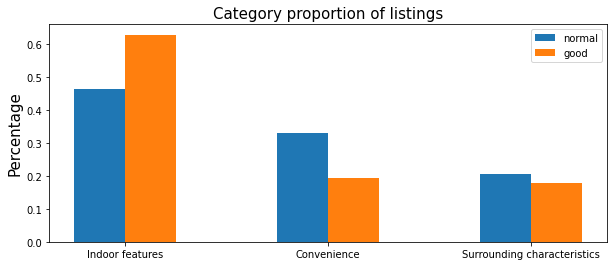

In [73]:
# compare the difference by bar chart

N=3
fig, ax = plt.subplots(figsize=(10,4))
ind = np.arange(N)    # the x locations for the groups
width = 0.25        # the width of the bars
label_category = ['Indoor features','Convenience','Surrounding characteristics']
ax.bar(ind, catogory_percentage_normal, width,label='normal')

ax.bar(ind + width, catogory_percentage_good, width,label='good')

ax.set_ylabel('Percentage',fontsize = 15)
ax.set_title('Category proportion of listings',fontsize = 15)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(label_category)

ax.legend()
plt.show()

From the bar chart above we can see among the three categories, Good listings are more about the indoor features while normal listings pay more attention to the convenience and the surrounding characteristics. 

Therefore, the different performance of listings may be influenced by the listing description. More description related to listing's indoor features may lead to good performance and get high review score from customers.

Next we will analyse the amenity items of the listings to see if good listings have better indoor amenities.

### Frequency analysis for listing amenity items

In each Airbnb listing, the amenities are chosen by the host from an amenity list provided by Airbnb. The analysis for amenities is to find the frequency of each amenity item occurring in all listings and identify the most used items in the two sub-groups.

##### Amenity items analysis for good listings

In [74]:
# select the amenities column
amenity_good = countryside_good['amenities']

In [75]:
amenity_good_pd = pd.DataFrame(amenity_good)

In [76]:
# get the unique amenity items
amenity_good_type = list(set(amenity_good.apply(lambda x: x[1:-1].replace("\"","").split(",")).sum()))

In [77]:
# get the isting-amenity_item matrix
amenity_good_type = [i for i in amenity_good_type if i!=""]

for a in amenity_good_type:
    amenity_good_pd[a] = amenity_good_pd['amenities'].str.contains(a)

<ipython-input-77-a191f921e04a>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  amenity_good_pd[a] = amenity_good_pd['amenities'].str.contains(a)


In [78]:
amenity_good_pd.shape

(646, 114)

In [79]:
# get the frequency of each amenity items, Top 15
amenity_good_pd.mean().sort_values(ascending=False).head(15)

<ipython-input-79-7b9275536041>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  amenity_good_pd.mean().sort_values(ascending=False).head(15)


Heating                      0.982972
Wifi                         0.975232
Essentials                   0.953560
Kitchen                      0.928793
Washer                       0.899381
Hangers                      0.828173
Iron                         0.811146
Hair dryer                   0.732198
Laptop-friendly workspace    0.642415
Hot water                    0.599071
Dryer                        0.540248
Refrigerator                 0.476780
Oven                         0.434985
First aid kit                0.379257
Microwave                    0.377709
dtype: float64

we can see that Heating, Wifi, Essentials and Kitchen are the 4 most frequent items in amenity.

In [80]:
top_amenity_good = pd.DataFrame({'amenity':amenity_good_pd.mean().index, 'frequency_good':amenity_good_pd.mean().values})

<ipython-input-80-4ec14d942a40>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  top_amenity_good = pd.DataFrame({'amenity':amenity_good_pd.mean().index, 'frequency_good':amenity_good_pd.mean().values})


In [81]:
# get the frequency of each amenity items in this dataframe
top_amenity_good

,amenity,frequency_good
0,Ethernet connection,0.000000
1,Patio or balcony,0.000000
2,Children\u2019s books and toys,0.000000
3,Lake access,0.000000
4,Pack \u2019n Play/travel crib,0.000000
...,...,...
108,Iron,0.000000
109,Air conditioning,0.037152
110,First aid kit,0.000000
111,Fireplace guards,0.010836


##### Amenity items analysis for Normal listings

In [82]:
#amenity_normal
amenity_normal = countryside_normal['amenities']
amenity_normal_pd = pd.DataFrame(amenity_normal)
amenity_normal_type = list(set(amenity_normal.apply(lambda x: x[1:-1].replace("\"","").split(",")).sum()))
len(amenity_normal_type)

110

In [83]:
amenity_normal_type = [i for i in amenity_normal_type if i!=""]

for a in amenity_normal_type:
    amenity_normal_pd[a] = amenity_normal_pd['amenities'].str.contains(a)
amenity_normal_pd.shape

<ipython-input-83-770ec2985e85>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  amenity_normal_pd[a] = amenity_normal_pd['amenities'].str.contains(a)


(569, 110)

In [84]:
#top_amenity_normal = pd.DataFrame(data=amenity_normal_pd.mean(),columns=['frequency_normal'])

In [85]:
amenity_normal_pd.mean().sort_values(ascending=False).head(15)

<ipython-input-85-5b32d1953724>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  amenity_normal_pd.mean().sort_values(ascending=False).head(15)


Heating                      0.961336
Wifi                         0.938489
Essentials                   0.917399
Kitchen                      0.894552
Smoke alarm                  0.889279
Hair dryer                   0.743409
Hot water                    0.659051
Laptop-friendly workspace    0.634446
Refrigerator                 0.511424
Oven                         0.423550
Stove                        0.411248
Microwave                    0.409490
Dryer                        0.391916
First aid kit                0.362039
Private entrance             0.297012
dtype: float64

We can see that Heating, Wifi, Essentials and Kitchen are the 4 most frequent items in amenity, which is the same as good listings.

In [86]:
top_amenity_normal = pd.DataFrame({'amenity':amenity_normal_pd.mean().index, 'frequency_normal':amenity_normal_pd.mean().values})

<ipython-input-86-0489dd21580a>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  top_amenity_normal = pd.DataFrame({'amenity':amenity_normal_pd.mean().index, 'frequency_normal':amenity_normal_pd.mean().values})


In [87]:
top_amenity_normal

,amenity,frequency_normal
0,Ethernet connection,0.000000
1,Patio or balcony,0.000000
2,Children\u2019s books and toys,0.000000
3,Lake access,0.000000
4,Pack \u2019n Play/travel crib,0.000000
...,...,...
104,Iron,0.000000
105,Air conditioning,0.056239
106,First aid kit,0.000000
107,Fireplace guards,0.012302


##### Compare the amenity items of good and normal listings

In [88]:
# merge the good and normal listing
amenities_compare = top_amenity_normal.merge(top_amenity_good, how='outer')

In [89]:
# prepare the data for display
normal_amenity_top = amenities_compare.sort_values(by='frequency_normal',ascending=False).head(10).frequency_normal
good_amenity_top = amenities_compare.sort_values(by='frequency_normal',ascending=False).head(10).frequency_good
label = amenities_compare.sort_values(by='frequency_normal',ascending=False).head(10).amenity.values


In [90]:
label = label.tolist()

In [91]:
label

['Heating',
 'Wifi',
 'Essentials',
 'Kitchen',
 'Smoke alarm',
 'Hair dryer',
 'Hot water',
 'Laptop-friendly workspace',
 'Refrigerator',
 'Oven']

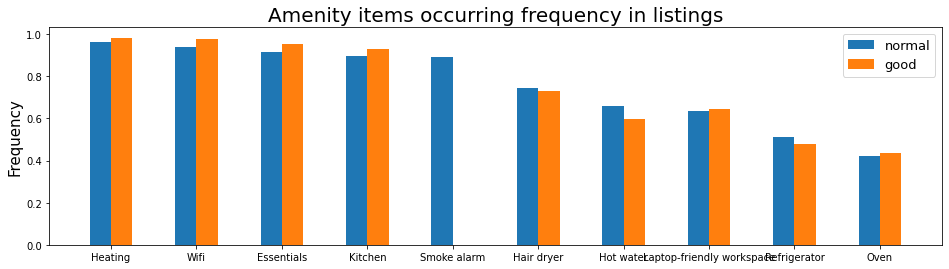

In [92]:
# create the bar chart to compare the amenity item frequency in good and normal listings

N=10
fig, ax = plt.subplots(figsize=(16,4))
ind = np.arange(N)    # the x locations for the groups
width = 0.25        # the width of the bars
ax.bar(ind, normal_amenity_top, width,label='normal')

ax.bar(ind + width, good_amenity_top, width,label='good')

ax.set_ylabel('Frequency',fontsize = 15)
ax.set_title('Amenity items occurring frequency in listings',fontsize = 20)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(label)

ax.legend(fontsize = 13)
plt.show()

The bar chart shows that among the 10 top items, good listings group has 6 of them higher than the normal ones. For the top 4 items in normal listings, their frequency are all lower than good listings, which indicates that the amenities quality in normal listings are not as good as the good listings. This may be the reason why the normal listings’ hosts did not write more about the indoor features in the listing description.

Therefore, the reason why listing performance is different may be that in the countryside some rooms do not have high quality indoor facilities, so the hosts provide less information about this and pay more attention on the surrounding characteristics to attract tourists. However, people have enough Airbnb listings to choose in those areas so the surrounding tourist attractions would not be a big advantage. Finally, more tourists would choose the listings with better indoor amenities equipped which leads to the higher review scores of those listings. 